# HW 11 CLUSTER BUSINESS:
# cluster time trends in NYC businesses
### Author : Le Xu ( lx565 )
### Data1: Census Business data
http://www.census.gov/econ/cbp/download/
### Data2: NYC zip codes shape file
https://github.com/fedhere/PUI2016_fb55/blob/master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson

In [219]:
import pandas as pd
import numpy as np
import zipfile
import pygeoj
from geopandas import GeoDataFrame
import glob
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster as scp
from sklearn.cluster import AgglomerativeClustering

In [184]:
list_of_files = glob.glob('*.zip') 

In [185]:
list_of_files

['zbp00totals.zip',
 'zbp01totals.zip',
 'zbp02totals.zip',
 'zbp03totals.zip',
 'zbp04totals.zip',
 'zbp05totals.zip',
 'zbp06totals.zip',
 'zbp07totals.zip',
 'zbp08totals.zip',
 'zbp09totals.zip',
 'zbp10totals.zip',
 'zbp11totals.zip',
 'zbp12totals.zip',
 'zbp13totals.zip',
 'zbp14totals.zip',
 'zbp94totals.zip',
 'zbp95totals.zip',
 'zbp96totals.zip',
 'zbp97totals.zip',
 'zbp98totals.zip',
 'zbp99totals.zip']

In [186]:
yearlist = []
for i, name in enumerate(list_of_files):
    yearlist.append(name[3:5])

## Extract the EST colunms for analysis from all the zip files

In [187]:
for i, name in enumerate(list_of_files):
    ## for 00 - 09 the est is the last column
    ## for 10 - 14 the est is the 9th colunm
    ## for 94 - 99 the est is the last column
    if i == 0:
        zf = zipfile.ZipFile(name)
        df = pd.read_csv(zf.open(name.replace('.zip','.txt')))
        df.rename(columns=lambda x: (str(x)).upper(), inplace=True)
        df = df.iloc[:, (0, -1)]
        
    elif (i < 10 and i > 0):
        zf = zipfile.ZipFile(name)
        df1 = pd.read_csv(zf.open(name.replace('.zip','.txt')))
        df1.rename(columns=lambda x: (str(x)).upper(), inplace=True)
        df1 = df1.iloc[:, (0, -1)]
        df = df.merge(df1, on = "ZIP", how = "inner")
    
    elif (i >= 10 and i <=14):
        zf = zipfile.ZipFile(name)
        df2 = pd.read_csv(zf.open(name.replace('.zip','.txt')))
        df2.rename(columns=lambda x: (str(x)).upper(), inplace=True)
        df2 = df2.iloc[:, (0, 9)]
        df = df.merge(df2, on = "ZIP", how = "inner")
    else:
        zf = zipfile.ZipFile(name)
        df3 = pd.read_csv(zf.open(name.replace('.zip','.txt')))
        df3.rename(columns=lambda x: (str(x)).upper(), inplace=True)
        df3 = df3.iloc[:, (0, -1)]
        df = df.merge(df3, on = "ZIP", how = "inner")

In [188]:
df.head()

,ZIP,EST_x,EST_y,EST_x,EST_y,EST_x,EST_y,EST_x,EST_y,EST_x,...,EST_y,EST_x,EST_y,EST_x,EST_y,EST_x,EST_y,EST_x,EST_y,EST
0,1001,493,490,490,505,500,509,509,503,477,...,436,453,439,458,439,439,433,457,444,469
1,1002,563,587,566,586,584,589,582,596,584,...,558,572,572,560,450,467,487,500,490,558
2,1003,13,13,15,16,15,12,12,16,17,...,16,15,15,18,10,10,13,15,14,13
3,1004,48,37,23,21,43,31,30,20,18,...,19,16,16,13,47,48,47,41,31,35
4,1005,86,90,94,93,97,94,98,106,97,...,91,94,97,97,92,95,101,104,95,82


In [189]:
df.index = df['ZIP']

In [190]:
df.drop(["ZIP"], axis = 1, inplace = True)

In [191]:
df.columns = yearlist

In [192]:
df.head()

,00,01,02,03,04,05,06,07,08,09,...,11,12,13,14,94,95,96,97,98,99
ZIP,,,,,,,,,,,,,,,,,,,,,
1001,493,490,490,505,500,509,509,503,477,458,...,436,453,439,458,439,439,433,457,444,469
1002,563,587,566,586,584,589,582,596,584,571,...,558,572,572,560,450,467,487,500,490,558
1003,13,13,15,16,15,12,12,16,17,16,...,16,15,15,18,10,10,13,15,14,13
1004,48,37,23,21,43,31,30,20,18,18,...,19,16,16,13,47,48,47,41,31,35
1005,86,90,94,93,97,94,98,106,97,87,...,91,94,97,97,92,95,101,104,95,82


---

## Import shaplefile

In [193]:
zip_shape = GeoDataFrame.from_file('nyc-zip-code-tabulation-areas-polygons.geojson')

In [194]:
zip_shape.rename(columns = {"postalCode": "ZIP"}, inplace= True)

In [195]:
zip_shape_poly = zip_shape.iloc[:,(-2,-1)]

In [196]:
zip_shape_poly.head()

,geometry,ZIP
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [197]:
zip_shape_poly.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 2 columns):
geometry    262 non-null object
ZIP         262 non-null object
dtypes: object(2)
memory usage: 4.2+ KB


In [198]:
zip_shape_poly.ZIP = zip_shape_poly.ZIP.astype(int)

#  Standardize time series

In [199]:
df.head()

,00,01,02,03,04,05,06,07,08,09,...,11,12,13,14,94,95,96,97,98,99
ZIP,,,,,,,,,,,,,,,,,,,,,
1001,493,490,490,505,500,509,509,503,477,458,...,436,453,439,458,439,439,433,457,444,469
1002,563,587,566,586,584,589,582,596,584,571,...,558,572,572,560,450,467,487,500,490,558
1003,13,13,15,16,15,12,12,16,17,16,...,16,15,15,18,10,10,13,15,14,13
1004,48,37,23,21,43,31,30,20,18,18,...,19,16,16,13,47,48,47,41,31,35
1005,86,90,94,93,97,94,98,106,97,87,...,91,94,97,97,92,95,101,104,95,82


### subtract the mean and divide each time series (separately) by its standard deviation. 

In [200]:
df_mean = df.mean(axis = 1) # for mean of row, add columns up , use axis 1
df_std = df.std(axis = 1) 

In [201]:
df_mean.head()

ZIP
1001    469.000000
1002    552.000000
1003     14.285714
1004     29.666667
1005     94.571429
dtype: float64

In [202]:
df = df.apply(lambda x: (x - df_mean)/df_std)

In [203]:
df.reset_index(inplace= True)

In [204]:
df.head()

,ZIP,00,01,02,03,04,05,06,07,08,...,11,12,13,14,94,95,96,97,98,99
0,1001,0.878467,0.768659,0.768659,1.317700,1.134686,1.464112,1.464112,1.244495,0.292822,...,-1.207892,-0.585645,-1.098084,-0.402631,-1.098084,-1.098084,-1.317700,-0.439233,-0.915070,0.000000
1,1002,0.249184,0.792858,0.317143,0.770205,0.724899,0.838164,0.679593,0.996736,0.724899,...,0.135919,0.453062,0.453062,0.181225,-2.310615,-1.925513,-1.472451,-1.177961,-1.404492,0.135919
2,1003,-0.598539,-0.598539,0.332521,0.798052,0.332521,-1.064069,-1.064069,0.798052,1.263582,...,0.798052,0.332521,0.332521,1.729112,-1.995129,-1.995129,-0.598539,0.332521,-0.133009,-0.598539
3,1004,1.499244,0.599698,-0.545180,-0.708734,1.090360,0.109036,0.027259,-0.790511,-0.954065,...,-0.872288,-1.117619,-1.117619,-1.362949,1.417467,1.499244,1.417467,0.926806,0.109036,0.436144
4,1005,-1.525824,-0.813773,-0.101722,-0.279734,0.432317,-0.101722,0.610330,2.034432,0.432317,...,-0.635760,-0.101722,0.432317,0.432317,-0.457747,0.076291,1.144368,1.678406,0.076291,-2.237875


# Merge the Census business dataframe with shapefile dataframe with same zipcode

In [205]:
mydata = zip_shape_poly.merge(df, on = "ZIP", how ="inner")

In [206]:
mydata.shape

(243, 23)

In [207]:
mydata.head()

,geometry,ZIP,00,01,02,03,04,05,06,07,...,11,12,13,14,94,95,96,97,98,99
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372,-0.533825,-0.540029,-0.198818,0.161004,0.365731,0.272673,0.198227,0.309896,...,0.942687,1.420382,1.637516,1.693350,-1.650515,-1.607088,-1.259673,-1.154208,-0.893647,-0.738551
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004,-1.202433,-0.518739,-0.062943,0.575171,0.484012,0.438432,0.484012,1.030967,...,0.301694,1.167706,1.167706,1.577923,-0.974535,-1.248013,-1.794968,-1.065695,-0.974535,-1.339172
2,POLYGON ((-73.70098278625547 40.73889569923034...,11040,-1.161866,-1.292342,-0.465989,-0.393502,-0.350009,0.157401,0.345867,0.838780,...,0.838780,1.157723,1.578149,1.505662,-0.118051,-0.234030,-1.379327,-1.248850,-1.248850,-1.161866
3,POLYGON ((-73.72270447144122 40.75373371438336...,11426,-0.649293,-0.512600,-0.854333,-0.717639,-0.375906,-0.205040,-0.205040,-0.136693,...,0.820159,1.161892,0.888506,0.956853,3.212291,-0.444253,-0.785986,-1.161892,-0.991026,-0.512600
4,POLYGON ((-73.81088634744755 40.72717187575918...,11365,-0.507127,-0.222956,-0.222956,-0.114700,0.115344,0.183004,0.237132,0.358920,...,1.170839,1.197903,1.671522,1.901566,-1.332578,-1.549090,-1.454366,-0.926619,-1.102534,-0.967215


# Kmeans Clustering & plot the cluster centers 

## Use the two years to plot, 2008 AND 1995

In [208]:
EST8 =  mydata.iloc[:,10]
EST95 =  mydata.iloc[:,18]

In [209]:
labels

array([1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 3, 0, 1, 1,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 3, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 3, 2, 3, 0, 0, 2, 0, 0, 2, 1, 0, 3, 0,
       3, 1, 0, 0, 1, 3, 0, 1, 3, 0, 0, 3, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       3, 1, 3, 1, 3, 0, 2, 2, 2, 0, 1, 0, 1], dtype=int32)

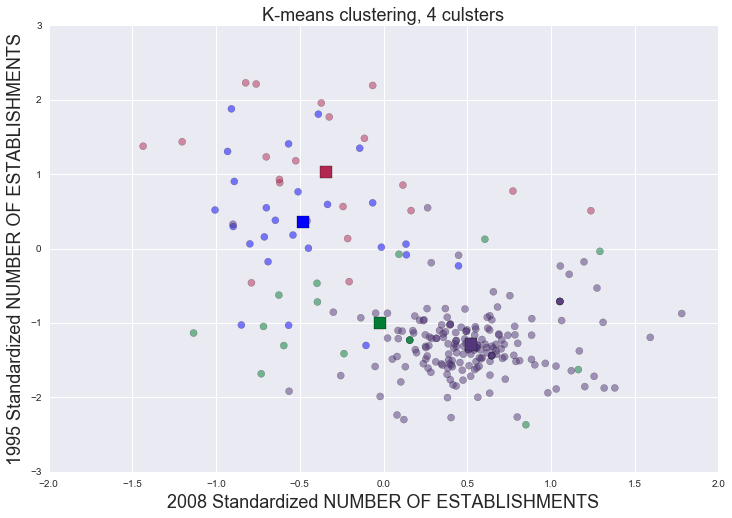

In [210]:
nk = 4
fig = plt.figure(figsize = (12,8))
model = KMeans(n_clusters=4).fit(mydata.iloc[:,2:])
centers = model.cluster_centers_
labels = model.labels_
colors=['#B32851','#53377A','#0000FF','#007D34']
col_map=dict(zip(set(labels),colors))
label_color = [col_map[l] for l in labels]
center_label = range(4)
plt.scatter(EST8, EST95, c= label_color, alpha = 0.5, s = 50) 
plt.scatter(centers[:,8], centers[:,16], c= [col_map[l] for l in center_label], s= 150, marker = "s", alpha = 1)
plt.xlabel("2008 Standardized NUMBER OF ESTABLISHMENTS", fontsize=18)
plt.ylabel("1995 Standardized NUMBER OF ESTABLISHMENTS", fontsize=18)
plt.title("K-means clustering, %d culsters"%nk, fontsize=18)

## Graph Caption: This the kmeans cluster, with 4 clusters, of the datapoints of year 2008's standardized numbers of business establishments and 1995's, the 4 big square are the cluster centers. We can easily see the centers are in the middle of their clusters.


## Explore the data:

In [211]:
mydata["label"] = labels

In [212]:
yearlist

['00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99']

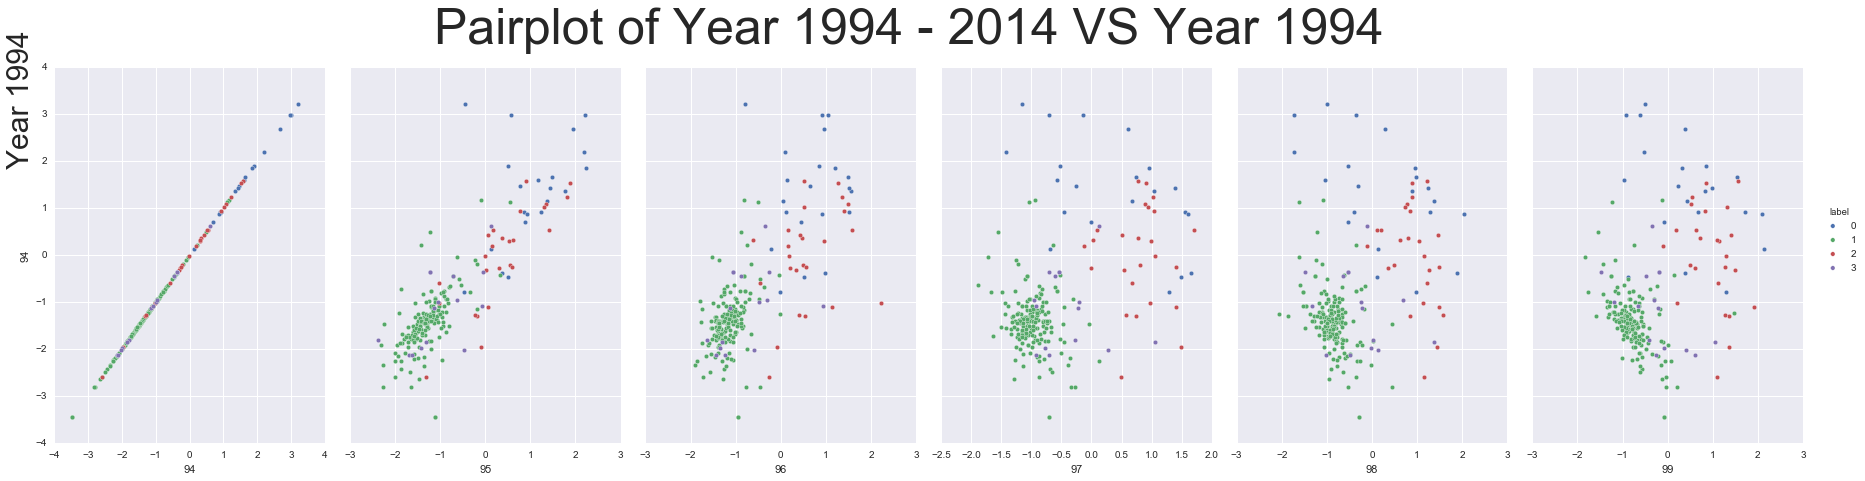

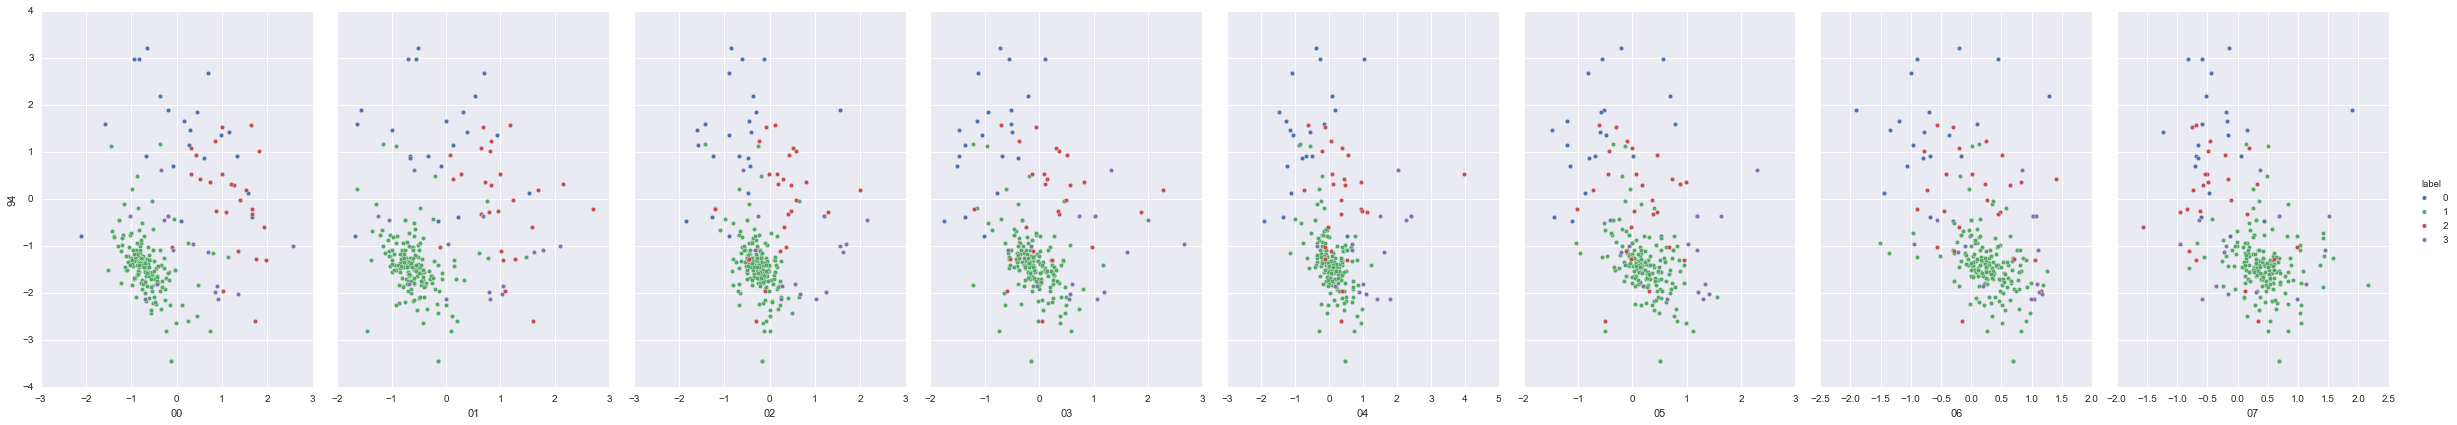

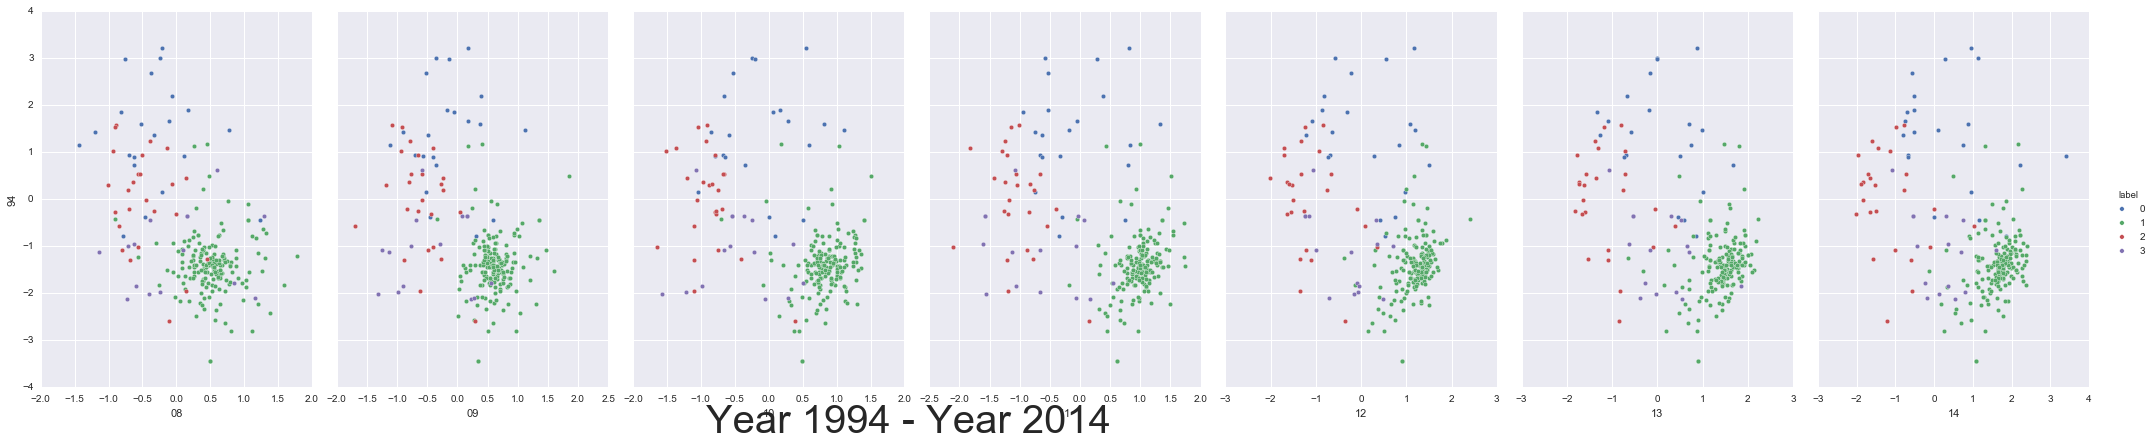

In [213]:

year9499 = sns.pairplot(mydata, x_vars = yearlist[-6:], #year 94-99
             y_vars = "94", size = 6, aspect = 0.7, hue = "label" )
year0007 = sns.pairplot(mydata, x_vars = yearlist[:8], #year 00-07
             y_vars = "94", size = 6, aspect = 0.7, hue = "label" )
year0814 = sns.pairplot(mydata, x_vars = yearlist[8:15], #year 08-14
             y_vars = "94", size = 6, aspect = 0.7, hue = "label" )

year9499.fig.text(0.23, 1.02,'Pairplot of Year 1994 - 2014 VS Year 1994', fontsize=50)
year9499.fig.text(0, 1,'Year 1994', fontsize=30, rotation=90)
year0814.fig.text(0.33, -0.01, 'Year 1994 - Year 2014', ha ='left', fontsize = 40)

## Graph Caption: This is just a rough pairplot contains 21 individual plots, done by seaborn,  the scatter points are the standardized numbers of establishments colored with with 4 clusters label(colors). All the plots have the same y axis, which is year 1994, each x axis is from year 1994 to 2014. As we can see, there is an interesting shifts for the cluster centers since 1994. There are clusters has increased its center, from left to right, or decreased, as from right to left. Probably it will be due to some neighborhood's gentrification, or development, or slowdown.  

# Agglomerative

In [214]:
agc = AgglomerativeClustering(n_clusters=4, compute_full_tree=True).fit(mydata.iloc[:,2:])
labelsag = agc.labels_


In [215]:
mydata["labelsag"] = labelsag

## Use the two years to plot, 2008 AND 1995

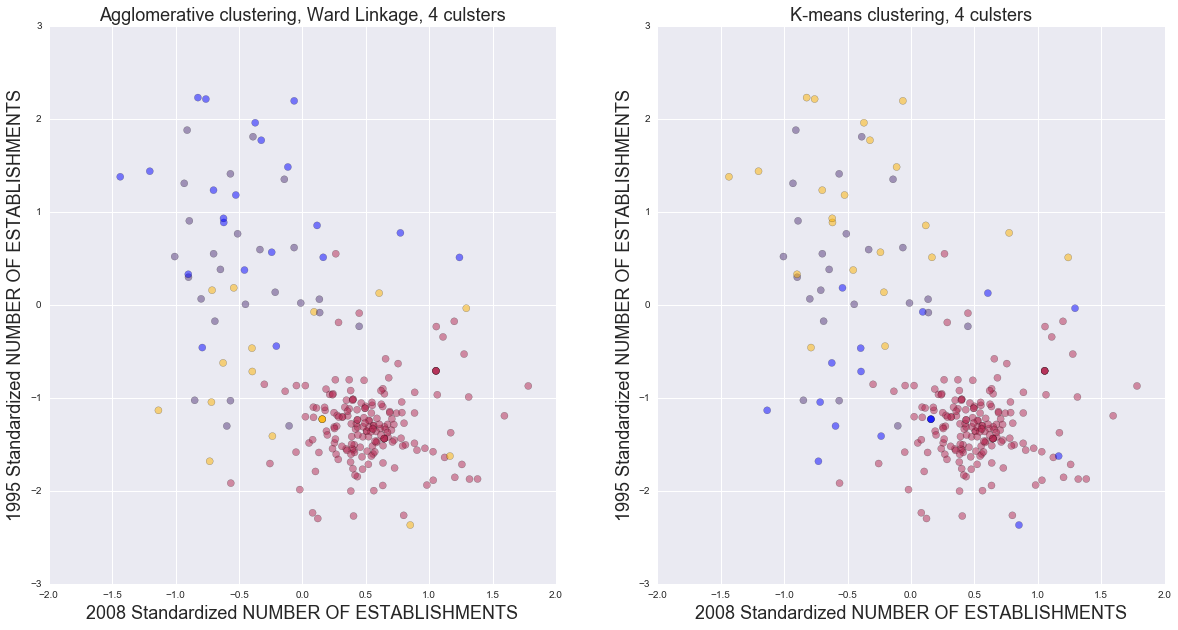

In [216]:
nk = 4
fig, ax = plt.subplots(1, 2, figsize = (20,10))
#centers = model.cluster_centers_
#labels = model.labels_
colors=['#B32851','#53377A','#0000FF','#FFB300']
col_map=dict(zip(set(labelsag),colors))
labelsag_color = [col_map[l] for l in labelsag]
ax[0].scatter(EST8, EST95, c= labelsag_color, alpha = 0.5, s = 50) 
#plt.scatter(centers[:,8], centers[:,16], c ="r", s= 150, marker = "8", alpha = 1)

ax[0].set_xlabel("2008 Standardized NUMBER OF ESTABLISHMENTS", fontsize=18)
ax[0].set_ylabel("1995 Standardized NUMBER OF ESTABLISHMENTS", fontsize=18)
ax[0].set_title("Agglomerative clustering, Ward Linkage, 4 culsters", fontsize=18)


model = KMeans(n_clusters=4).fit(mydata.iloc[:,2:])
centers = model.cluster_centers_
labels = model.labels_
col_map=dict(zip(set(labels),colors))
label_color = [col_map[l] for l in labels]
ax[1].scatter(EST8, EST95, c= label_color, alpha = 0.5, s = 50) 
#ax[1].scatter(centers[:,8], centers[:,16], c ="r", s= 150, marker = "8", alpha = 1)
ax[1].set_xlabel("2008 Standardized NUMBER OF ESTABLISHMENTS", fontsize=18)
ax[1].set_ylabel("1995 Standardized NUMBER OF ESTABLISHMENTS", fontsize=18)
ax[1].set_title("K-means clustering, %d culsters"%nk, fontsize=18)

## Graph Caption: Left plot is the Agglomerative cluster, with 4 clusters, of the datapoints of year 2008's standardized numbers of business establishments and 1995's. The points are colored by their labels of the cluster. The right plot is the Kmeans cluster with same data. By comparing two plot by eyes, they are very similiar.
---



## Agglomerative cluster on Eucledian distance dendrogram

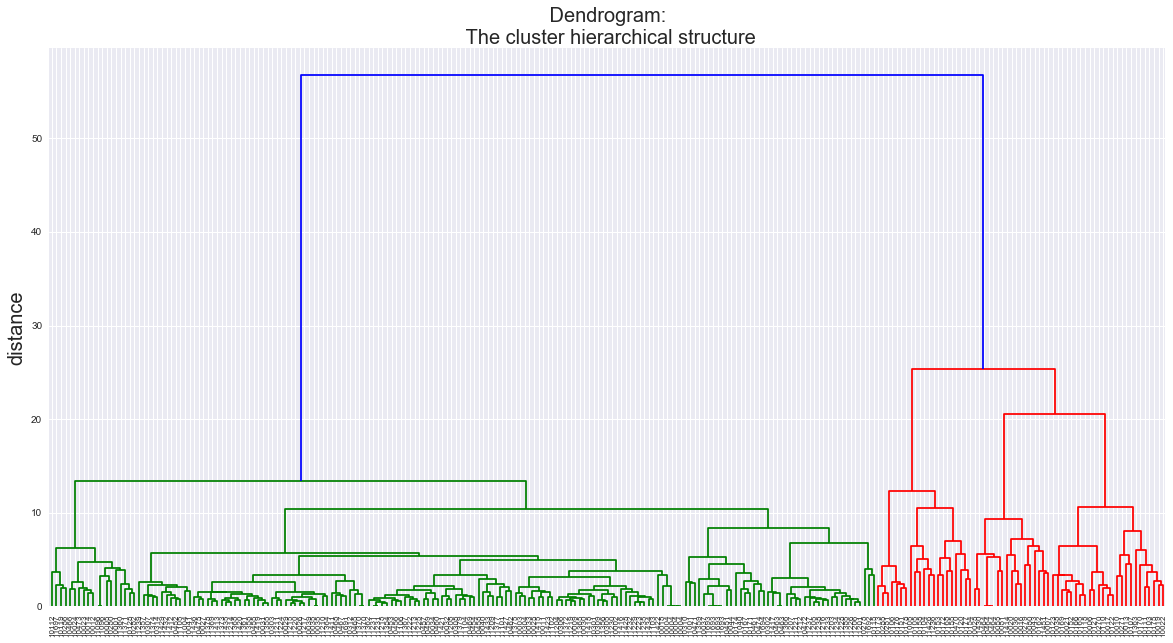

In [217]:
fig = plt.figure(figsize=(20,10))
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(mydata.iloc[:,2:], method='ward'),
                               labels = mydata.ZIP.values,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.)  
plt.xticks(rotation=90)
plt.ylabel("distance", fontsize = 20)
plt.title(" Dendrogram: \n The cluster hierarchical structure", fontsize=20)

## Graph caption: Dandrogram of numbers of Business Establishment over different zipcodes clusters from 1994-2014, with Ward method.


## Overlay data on a NYC map

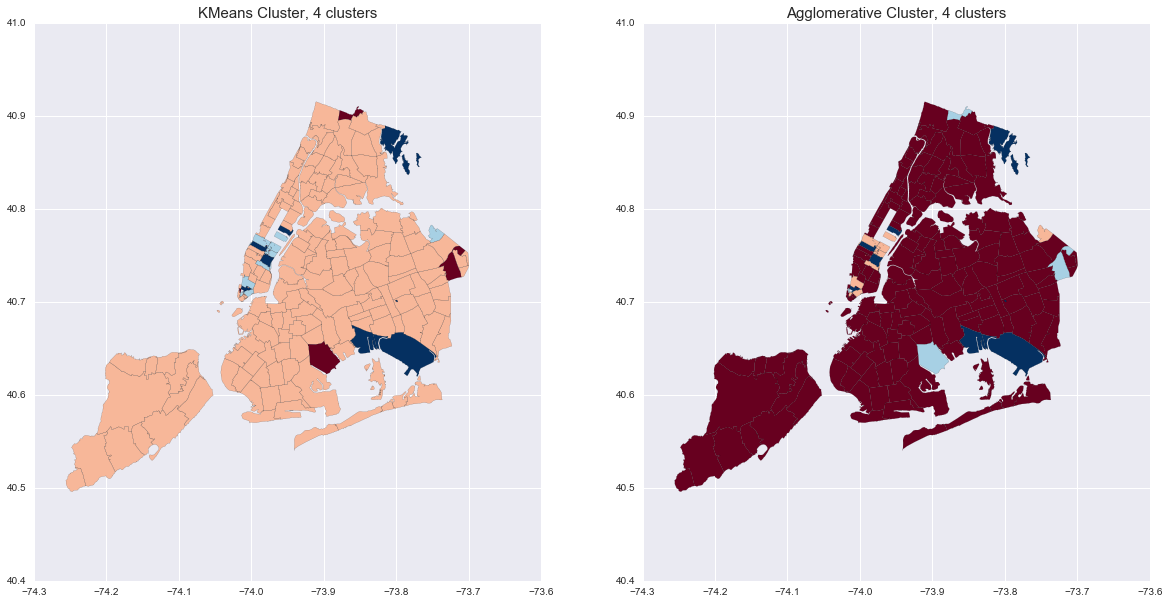

In [218]:
f, ax = plt.subplots(1, 2, figsize = (20,10))
mydata.plot(column='label', alpha=1, linewidth=0.1, ax= ax[0], cmap="RdBu")
ax[0].set_title("KMeans Cluster, 4 clusters", fontsize = 15)
mydata.plot(column='labelsag', alpha=1, linewidth=0.1, ax= ax[1], cmap="RdBu")
ax[1].set_title("Agglomerative Cluster, 4 clusters", fontsize = 15)

## Gragh Caption:  The above plots are areas of zipcodes clustered based on its numbers of business establishment from 1994 to 2014, with four different cluster labels(colors). 
## From those two plots, we can see there is a smiliarity of the results of both methods of clustering. One evident difference is the area of JFK airport area, which is in different cluster groups from two plots.